In [1]:
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np

In [2]:
dataset = ["yaz", "bakery","m5", "SID"]

best_results = pd.DataFrame()
cv_results = pd.DataFrame()

for d in dataset:
    best_results_temp = pd.read_csv("Results/best_results_"+d+".csv.zip")
    cv_results_temp = pd.read_csv("Results/cv_results_"+d+".csv.zip")
    best_results = pd.concat([best_results, best_results_temp],ignore_index=True)
    cv_results = pd.concat([cv_results, cv_results_temp],ignore_index=True)

## Best results

In [3]:
best_results['feature combi'] = best_results['feature combi'].map(lambda x: re.sub(r"[]'[]", "", x))
best_results['feature combi'] = best_results['feature combi'].str.replace('_m5', '')
best_results['feature combi'] = best_results['feature combi'].str.replace('_bakery', '')
best_results['feature combi'] = best_results['feature combi'].str.replace('_yaz', '')

In [4]:
# create column for rank
best_results["rank"] = best_results.groupby(["sl", "group", "dataset", "feature combi"])["coefficient of prescriptiveness"].rank("min", ascending=False)

In [5]:
# base case results
base_case = best_results[(best_results["sl"]==0.90) & (best_results["feature combi"]=="calendar, lag")]

# select the best model per group
best_model_per_group = best_results.loc[best_results.groupby(["sl", "group", "dataset", "feature combi"])['coefficient of prescriptiveness'].idxmax()]
best_model_per_group['model'] = pd.Categorical(best_model_per_group['model'], ["SAA", "KNNW", "DTW", "RFW", "GKW", "LR", "DL"])

# select the best model per group from for base cas
best_model_per_group_BC = best_model_per_group[(best_model_per_group["sl"]==0.9) & (best_model_per_group["feature combi"]=="calendar, lag")]


## CV Results

In [6]:
cv_results['feature combi'] = cv_results['feature combi'].map(lambda x: re.sub(r"[]'[]", "", x))
cv_results['feature combi'] = cv_results['feature combi'].str.replace('_m5', '')
cv_results['feature combi'] = cv_results['feature combi'].str.replace('_bakery', '')
cv_results['feature combi'] = cv_results['feature combi'].str.replace('_yaz', '')

In [7]:
# select best models per parameter gird
best_model_per_grid = cv_results.loc[cv_results.groupby(["model", "group", "dataset", "feature combi", "sl"])["mean_test_score"].idxmax()]

# create column for rank
best_model_per_grid["rank"] = best_model_per_grid.groupby(["group", "dataset", "feature combi", "sl"])["mean_test_score"].rank("min", ascending=False)

# select the best model per group from CV results
best_cv_model_per_group = best_model_per_grid.loc[best_model_per_grid.groupby(["group", "dataset", "feature combi", "sl"])['mean_test_score'].idxmax()]

# select columns
best_cv_model_per_group= best_cv_model_per_group.iloc[:,-10:]

# select the best model per group from CV results for base case
best_cv_model_per_group_bc = best_cv_model_per_group[(best_cv_model_per_group["feature combi"]=="calendar, lag") & (best_cv_model_per_group["sl"]==0.9)]

# Settings

In [8]:
datasets = best_results["dataset"].unique()

In [9]:
model_order = ["SAA", "KNNW", "DTW", "RFW", "GKW", "LR", "DL"]
cop_model_order = ["KNNW", "DTW", "RFW", "GKW", "LR", "DL"]

In [10]:
# color palette for different models
p = {"SAA": "xkcd:red", "RFW": "xkcd:blue", "DTW": "xkcd:sky blue", "KNNW":"xkcd:pinkish", "GKW": "xkcd:goldenrod", "LR": "xkcd:green", "DL": "xkcd:light brown", "ES": "xkcd:orange"}
#p = {"SAA": sns.color_palette("Set2",8)[0], "RFW": sns.color_palette("Set2",8)[1], "DTW": sns.color_palette("Set2",8)[2], "KNNW":sns.color_palette("Set2",8)[3], "GKW": sns.color_palette("Set2",8)[4], "LR": sns.color_palette("Set2",8)[5], "DL": sns.color_palette("Set2",8)[6], "ES": sns.color_palette("Set2",8)[7]}

# standard column for all plots
c = "#1f77b4"

# Main plots

## Model comparison CoP for base case

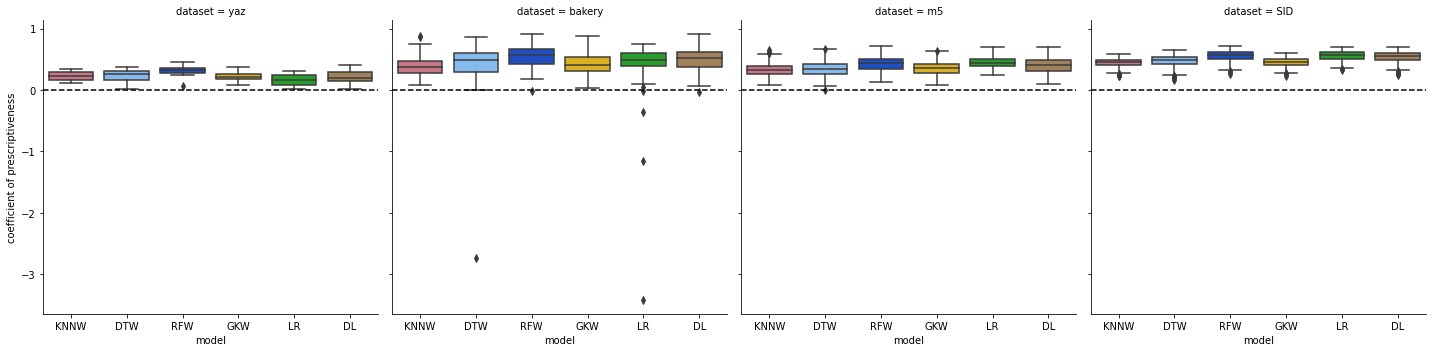

In [11]:
fig = sns.catplot(x="model", y="coefficient of prescriptiveness", data=base_case, kind="box", palette=p, col="dataset", order=cop_model_order)
for i in range(datasets.shape[0]):
    fig.axes[0][i].axhline(0, color="black", linestyle='--')

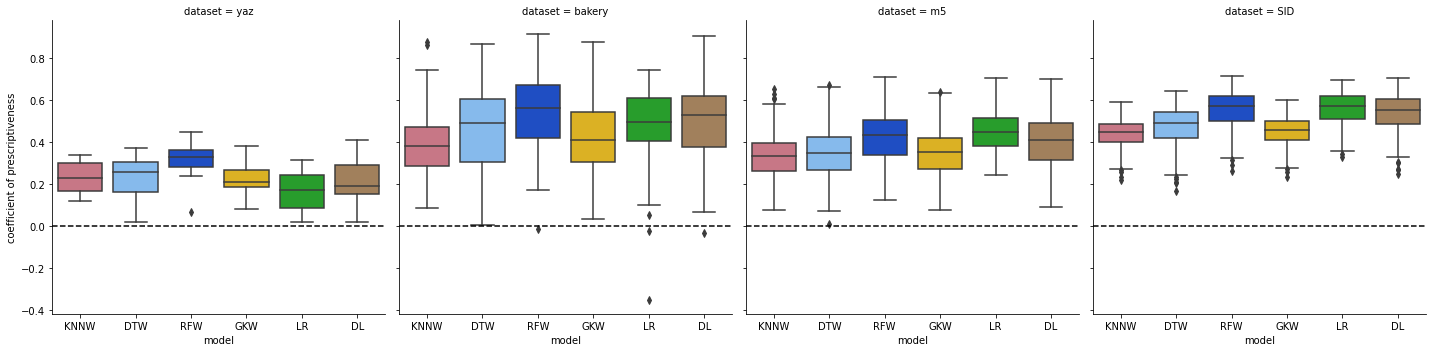

In [12]:
df = base_case.drop(base_case[(base_case['coefficient of prescriptiveness'] < -0.5)].index)
fig = sns.catplot(x="model", y="coefficient of prescriptiveness", data=df, kind="box", palette=p, col="dataset", order=cop_model_order)
for i in range(datasets.shape[0]):
    fig.axes[0][i].axhline(0, color="black", linestyle='--')
    

In [13]:
fig.savefig("plots/model comparison.png") 

# Rank plots

## Rank one overall

In [14]:
df = best_model_per_group["model"].value_counts(normalize=True).mul(100).rename('percent').reset_index()
df["percent"] = df["percent"].round(1)
df.rename(columns={'index': 'model'}, inplace=True)

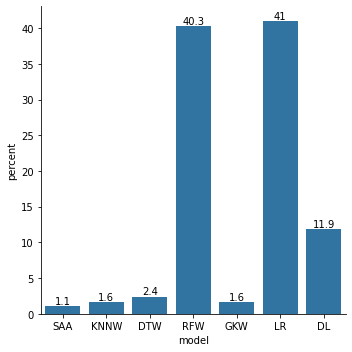

In [15]:
fig = sns.catplot(data=df, x="model",y='percent',kind='bar', color=c, order = model_order)
for ax in fig.axes[0]:
    ax.bar_label(ax.containers[0])

In [16]:
fig.savefig("plots/rank_one_overall.png")

## Rank one overall by dataset

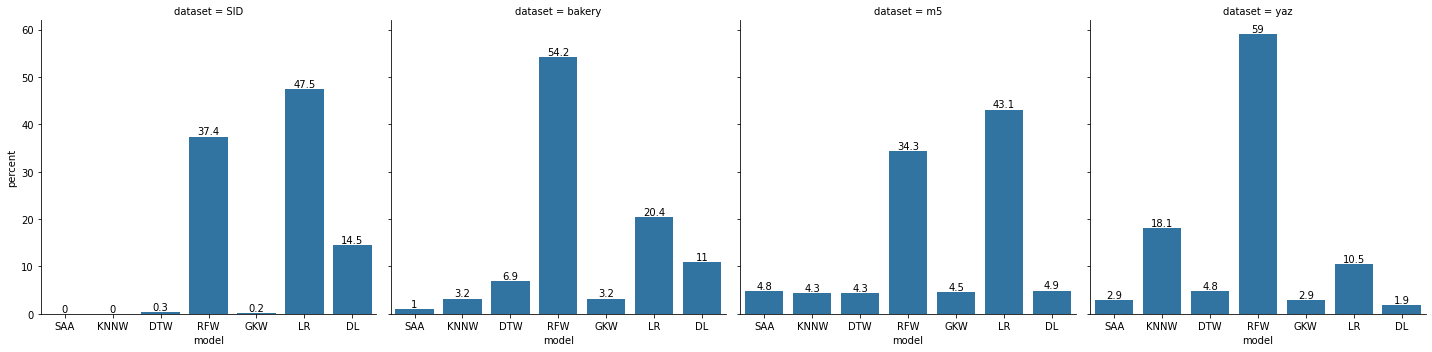

In [17]:
df = best_model_per_group.groupby(["dataset"])["model"].value_counts(normalize=True).mul(100).rename('percent').reset_index()
df["percent"] = df["percent"].round(1)
df.rename(columns={'level_1': 'model'}, inplace=True)

fig = sns.catplot(data=df, x="model",y='percent',col="dataset",kind='bar', color=c, order = model_order)

for ax in fig.axes[0]:
    ax.bar_label(ax.containers[0])

In [18]:
fig.savefig("plots/rank_one_overall_per_dataset.png")

## Rank one for base case

In [19]:
df = best_model_per_group_BC["model"].value_counts(normalize=True).mul(100).rename('percent').reset_index()
df["percent"] = df["percent"].round(1)
df.rename(columns={'index': 'model'}, inplace=True)

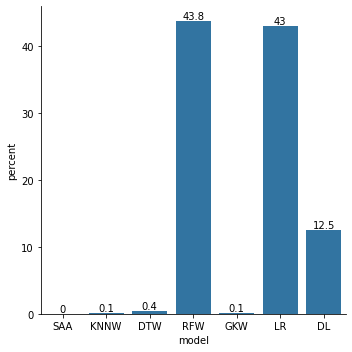

In [20]:
fig = sns.catplot(data=df, x="model",y='percent',kind='bar', color=c, order = model_order)
for ax in fig.axes[0]:
    ax.bar_label(ax.containers[0])

In [21]:
fig.savefig("plots/rank_one_base_case.png")

## Rank one by datasets for base case

In [22]:
df = best_model_per_group_BC.groupby(["dataset"])["model"].value_counts(normalize=True).mul(100).rename('percent').reset_index()
df["percent"] = df["percent"].round(1)
df.rename(columns={'level_1': 'model'}, inplace=True)

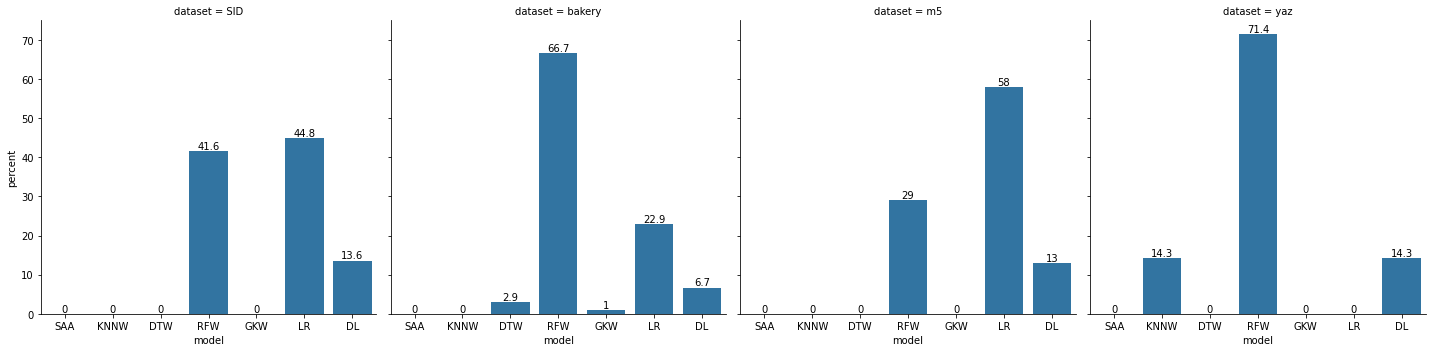

In [23]:
fig = sns.catplot(data=df, x="model",y='percent',col="dataset",kind='bar', color=c, order = model_order)

for ax in fig.axes[0]:
    ax.bar_label(ax.containers[0])

In [24]:
fig.savefig("plots/rank_one_per_dataset_base_case.png")

# Line Plots 

## Performance variation of service levels

calendar
calendar, lag
calendar, lag, special


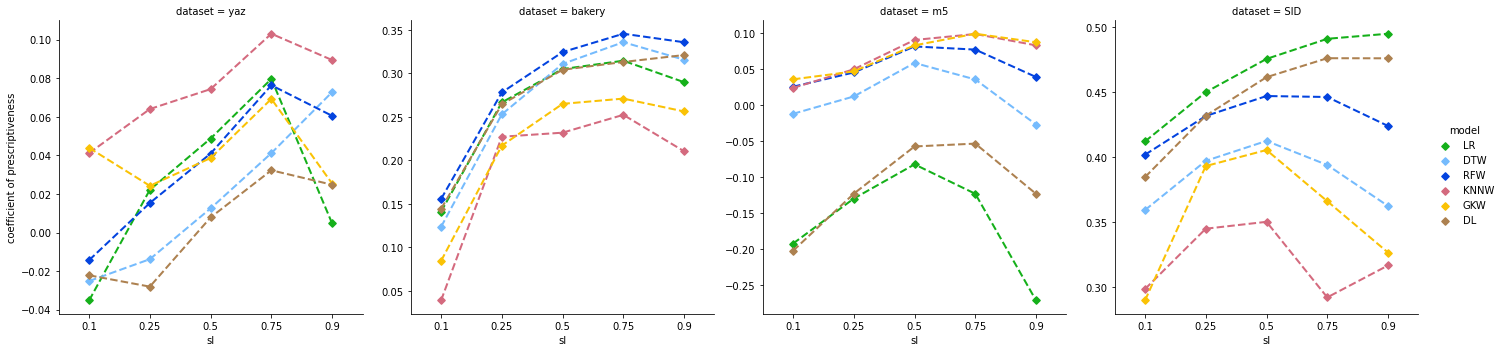

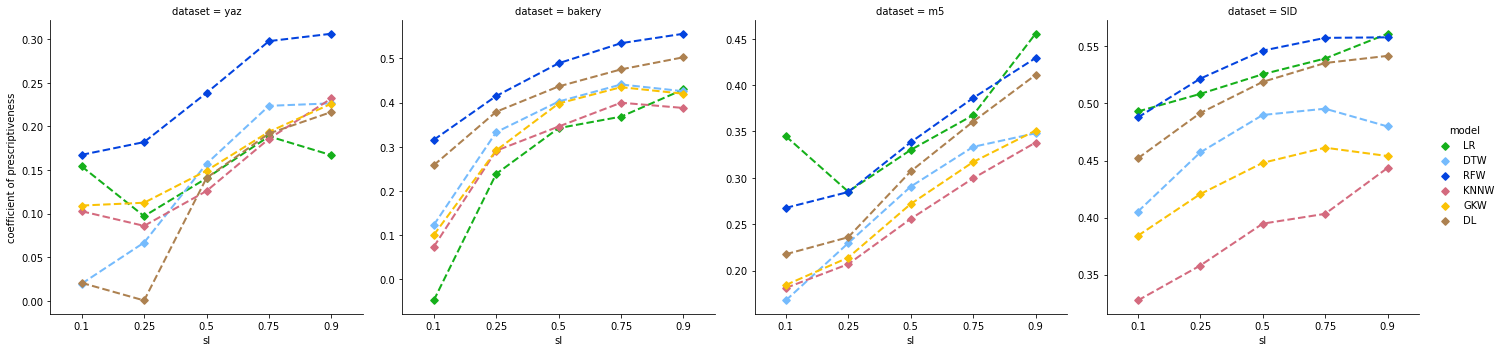

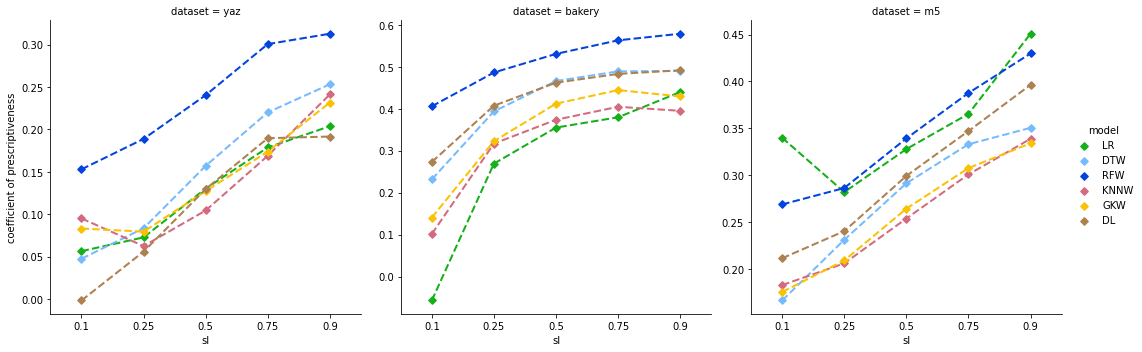

In [25]:
##################
### USER INPUT ###
##################

# Select metric to use ("Average costs" or "Coefficient of Prescriptiveness")
metric = "coefficient of prescriptiveness"

# Select Models to plot. Possible are: "SAA", "GKW", "KNNW", "DTW", "RFW", "LR", "DL"
models = ["GKW", "KNNW", "DTW", "RFW", "LR", "DL"]

# Select feature combis to plot
features = [
            "calendar",
            "calendar, lag",
            "calendar, lag, special"
           ]

for f in features:
    print(f)
    fig = sns.catplot(x="sl", hue="model", y=metric, data=best_results[(best_results["feature combi"]==f) & (best_results.model.isin(models))], kind="point", col="dataset", 
                      ci=None, sharey=False, 
                      palette=p, linestyles='--', markers='D', scale=0.75
                     )
    fig.figure.savefig("Plots/SL_variation_"+metric+" "+f+".png")  

## Performance variation of features

0.1
0.25
0.5
0.75
0.9


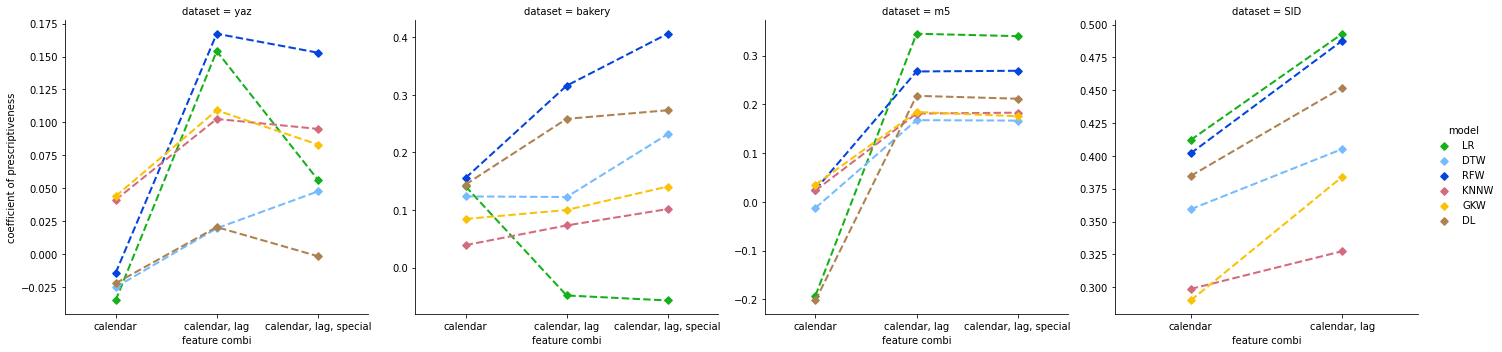

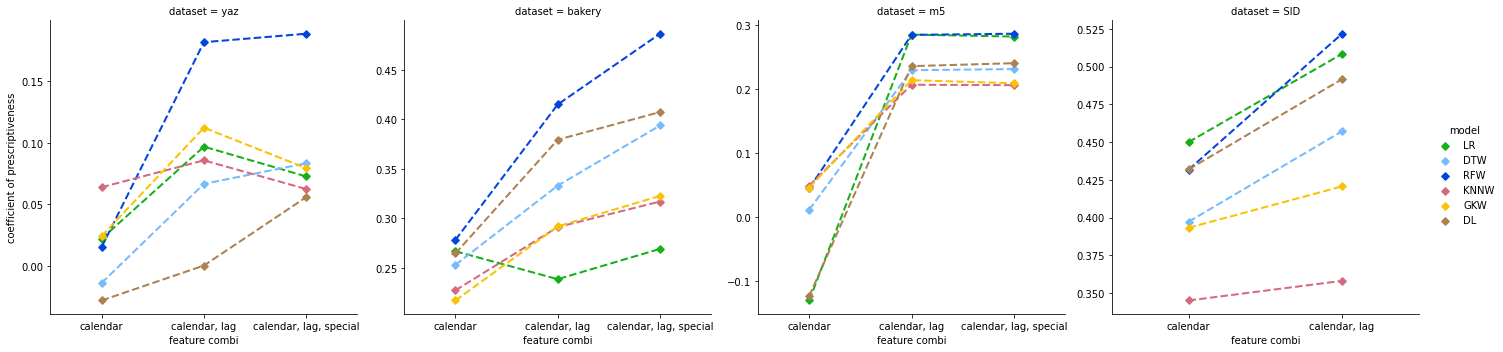

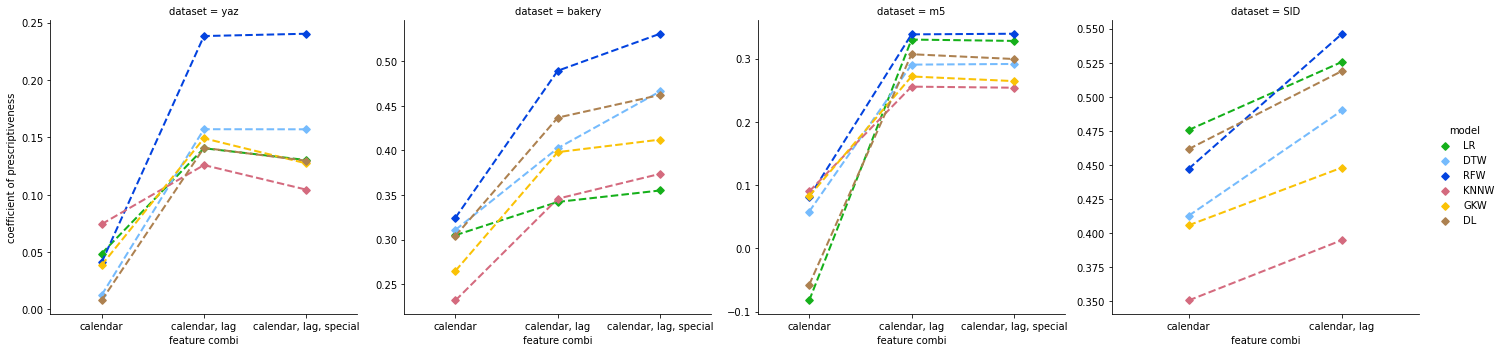

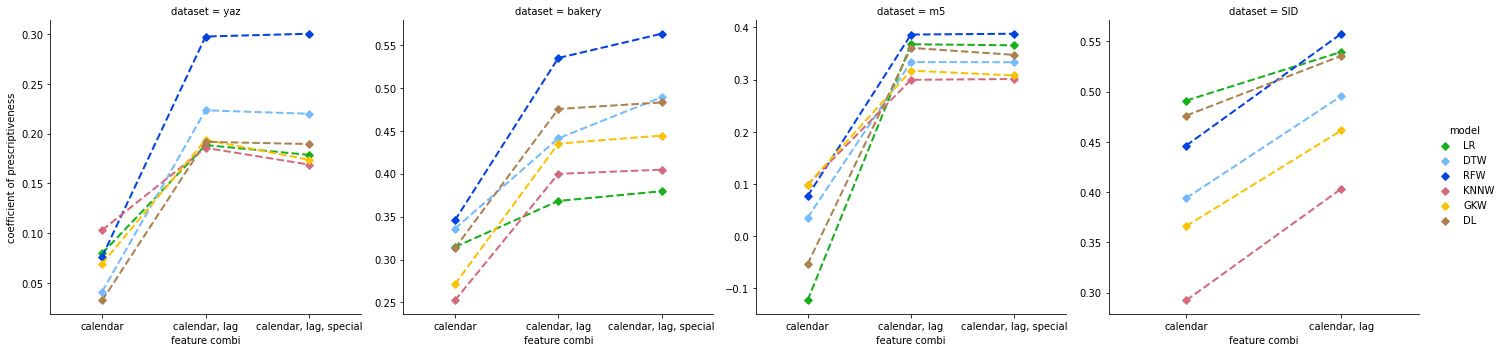

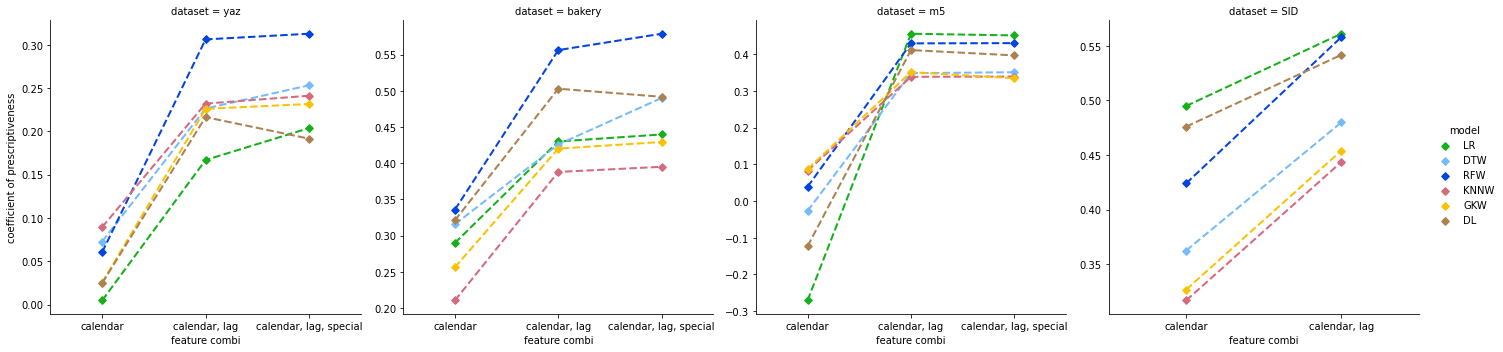

In [26]:
##################
### USER INPUT ###
##################

# Select metric to use ("Average costs" or "Coefficient of Prescriptiveness")
metric = "coefficient of prescriptiveness"

# Select Models to plot. Possible are: "SAA", "GKW", "KNNW", "DTW", "RFW", "LR", "DL"
models = ["GKW", "KNNW", "DTW", "RFW", "LR", "DL"]

# Select SLs to plot. Possible are: 0.1, 0.25, 0.5, 0.75, 0.9
SLs = [0.1, 0.25, 0.5, 0.75, 0.9]

for SL in SLs:
    print(SL)
    fig = sns.catplot(x="feature combi", hue="model", y= metric, data=best_results[(best_results["sl"]==SL) & (best_results.model.isin(models))], kind="point", col="dataset", 
                      ci=None, sharey=False, sharex=False, 
                      palette=p, linestyles='--', markers='D', scale=0.75)
    
    fig.figure.savefig("Plots/feature_variation_"+metric+" "+str(SL)+".png") 